In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn

In [2]:
!pip install transformers datasets pandas scikit-learn torch parquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.3/782.3 kB 18.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.6 MB/

In [3]:
# Imports
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score
import torch

# Load GoEmotions dataset from HuggingFace Parquet (already downloaded)
df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/simplified/train-00000-of-00001.parquet")

# Define emotion labels (28 classes)
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

# Convert list of label indices to multi-hot vectors
def multi_hot(labels, num_classes=28):
    result = []
    for label_list in labels:
        vec = [0] * num_classes
        for idx in label_list:
            vec[idx] = 1
        result.append(vec)
    return result

# Split and convert labels
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["labels"], test_size=0.2, random_state=42
)

train_labels = multi_hot(train_labels.tolist())
val_labels = multi_hot(val_labels.tolist())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize texts
train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding="max_length",
    max_length=128
)
val_encodings = tokenizer(
    val_texts.tolist(),
    truncation=True,
    padding="max_length",
    max_length=128
)

from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        # ⚠️ Cast labels to float for BCEWithLogitsLoss
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


# Create train/val datasets
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


In [12]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=28,
    problem_type="multi_label_classification"
)

# Metrics function
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    preds = (logits > 0).astype(int)
    f1 = f1_score(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train!
trainer.train()

# Evaluate on validation set
results = trainer.evaluate()
print(f"Validation F1: {results['eval_f1']:.3f}")
print(f"Validation Accuracy: {results['eval_accuracy']:.3f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.093900,0.090907,0.499838,0.365699
2,0.079500,0.084181,0.579507,0.465331
3,0.062300,0.086446,0.581380,0.466828


Validation F1: 0.580
Validation Accuracy: 0.465


In [14]:
# Sample prediction
sample_text = "I'm so excited about this project!"
sample_input = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)
sample_input = {k: v.to(model.device) for k, v in sample_input.items()}
outputs = model(**sample_input)

probs = torch.sigmoid(outputs.logits)
predicted_emotions = [emotion_labels[i] for i, p in enumerate(probs[0]) if p > 0.5]
print(f"Predicted Emotions: {predicted_emotions}")


model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

Predicted Emotions: ['excitement']


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

Accuracy: 0.465
F1-score (micro): 0.580
RMSE: 0.152

Classification Report:
                precision    recall  f1-score   support

    admiration       0.70      0.71      0.71       863
     amusement       0.75      0.82      0.78       453
         anger       0.68      0.37      0.48       323
     annoyance       0.48      0.13      0.20       483
      approval       0.54      0.22      0.31       577
        caring       0.44      0.44      0.44       212
     confusion       0.80      0.20      0.32       258
     curiosity       0.58      0.52      0.55       460
        desire       0.74      0.43      0.54       128
disappointment       0.54      0.06      0.11       244
   disapproval       0.52      0.13      0.21       383
       disgust       0.67      0.33      0.44       156
 embarrassment       0.84      0.36      0.51        58
    excitement       0.58      0.18      0.28       175
          fear       0.68      0.46      0.55       116
     gratitude       0.95  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


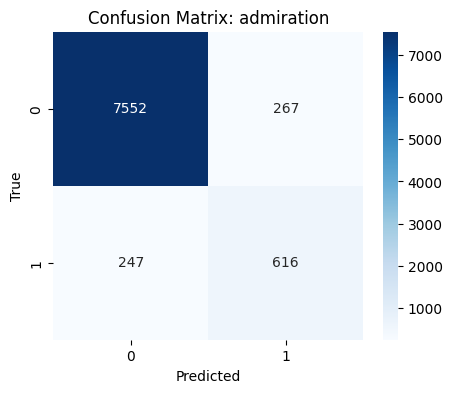

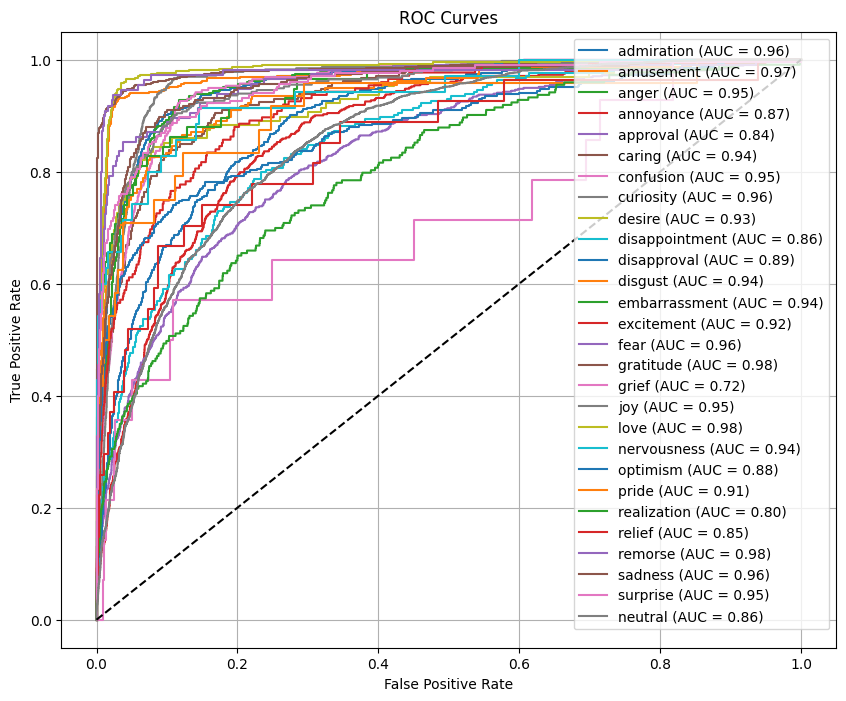


Per-Class RMSE:
admiration: 0.207
amusement: 0.133
anger: 0.152
annoyance: 0.213
approval: 0.227
caring: 0.143
confusion: 0.144
curiosity: 0.175
desire: 0.096
disappointment: 0.154
disapproval: 0.185
disgust: 0.111
embarrassment: 0.066
excitement: 0.125
fear: 0.088
gratitude: 0.099
grief: 0.040
joy: 0.148
love: 0.127
nervousness: 0.056
optimism: 0.157
pride: 0.051
realization: 0.149
relief: 0.055
remorse: 0.079
sadness: 0.138
surprise: 0.116
neutral: 0.378


In [13]:
# model evaluation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score, mean_squared_error
)
import torch

# Get predictions
predictions = trainer.predict(val_dataset)
logits = predictions.predictions
labels = predictions.label_ids

# Apply sigmoid and threshold
probs = torch.sigmoid(torch.tensor(logits)).numpy()
preds = (probs > 0.5).astype(int)

# === Basic Metrics ===
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="micro")
rmse = np.sqrt(mean_squared_error(labels, probs))

print(f"Accuracy: {accuracy:.3f}")
print(f"F1-score (micro): {f1:.3f}")
print(f"RMSE: {rmse:.3f}")

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=emotion_labels))

# === Confusion Matrix for first class ===
cm = confusion_matrix(labels[:, 0], preds[:, 0])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix: {emotion_labels[0]}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === ROC Curves for each class ===
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(len(emotion_labels)):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

# === RMSE Per Class ===
print("\nPer-Class RMSE:")
for i, label in enumerate(emotion_labels):
    class_rmse = np.sqrt(mean_squared_error(labels[:, i], probs[:, i]))
    print(f"{label}: {class_rmse:.3f}")
